# **The Simpsons Through the Data**

#### There is much to be learned from the popular and timeless series, The Simpsons. When deviating from the standard quantitative metrics like ratings and reach, we can find meaningful groups and topics within the data looking at characters, locations, and spoken lines within all 600 episodes of the Simpsons.

#### Working in the world of television, the main attribute to determine the success of an episode is often a rating or reach. What if we took the innate creative features of a program that are closer to a viewer’s knowledge and more salient. “Which of my favorite characters are in this episode?” “I laugh whenever Bart gets in trouble at Springfield Elementary School.” Homer’s lines are iconic.” We can take these attributes to classify the kinds of episodes that come out of the Simpsons. With the episode clusters, how well are they voted for on IMDB? How are they viewed?

#### Using a comprehensive dataset of 27 seasons of the Simpsons, what groups of episodes using creative attributes like characters, locations, and lines, can we find based on viewers, and which groups perform the best to inform creative content creators?

#### I expect to see clusters each with similar information. I believe the episodes with the most imdb views will likely be seasonal episodes. These episodes may also have fewer characters, since they often focus on the main cast. Since The Treehouse of Horror episodes are more topical and often based on real-world horror stories, more unusual locations may be present. I expect older episodes with a greater amount of characters to have the highest amounts of views. Creating interesting segments of Simpsons episodes that are similar and adequately different from other groups of episodes will be a success. I expect to see differing imdb scores for each cluster. To help add features to my dataset that can better show the success of an episode, I can match Nielsen data with each of the episode numbers to see a better representation of the success of an episode using each of the features.

In [2]:
# Unicode Handling
from __future__ import unicode_literals

import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.matutils import Sparse2Corpus
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import matplotlib.pyplot as plt
%matplotlib inline  

lines = pd.read_csv('simpsons_script_lines.csv')
eps = pd.read_csv('simpsons_episodes.csv').fillna(0)
chars = pd.read_csv('simpsons_characters.csv')
locs = pd.read_csv('simpsons_locations.csv')

#  <span style="color:blue"> Cleaning/Merging Datasets </span>

In [3]:
merged_df = pd.merge(eps, lines, left_on='id', right_on='episode_id')

In [4]:
epslineschars = pd.merge(merged_df, chars, left_on='raw_character_text', right_on='name')

In [5]:
data = epslineschars

In [6]:
data.head()

,id_x,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,...,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,id,name,normalized_name,gender
0,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,154.0,Eugene Fisk,PARTY ROOM,"I love you, Dad.",i love you dad,4.0,169,Eugene Fisk,eugene fisk,NaN
1,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,154.0,Mr. Fisk,PARTY ROOM,"I love you, son.",i love you son,4.0,168,Mr. Fisk,mr fisk,NaN
2,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,154.0,Mr. Fisk,PARTY ROOM,"And just as I was asking myself, ""Where did my...",and just as i was asking myself where did my s...,77.0,168,Mr. Fisk,mr fisk,NaN
3,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,154.0,Mr. Fisk,PARTY ROOM,"How do I tell you this, my boy? We're in hell.",how do i tell you this my boy were in hell,11.0,168,Mr. Fisk,mr fisk,NaN
4,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,91.0,Marge Simpson,Simpson Bathroom,So how was the office birthday party?,so how was the office birthday party,7.0,1,Marge Simpson,marge simpson,f


In [7]:
data.shape

(139442, 32)

In [8]:
data.columns

Index([u'id_x', u'title', u'original_air_date', u'production_code', u'season',
       u'number_in_season', u'number_in_series', u'us_viewers_in_millions',
       u'views', u'imdb_rating', u'imdb_votes', u'image_url', u'video_url',
       u'month', u'month_avg', u'id_y', u'episode_id', u'number', u'raw_text',
       u'timestamp_in_ms', u'speaking_line', u'character_id', u'location_id',
       u'raw_character_text', u'raw_location_text', u'spoken_words',
       u'normalized_text', u'word_count', u'id', u'name', u'normalized_name',
       u'gender'],
      dtype='object')

#  <span style="color:blue"> Feature Engineering </span>

### Separate characters into primary and secondary characters based on number of lines per episode

In [9]:
main_chars = data.groupby("name").count()["id"].sort_values(ascending=False)[0:4]/600

In [10]:
sec_chars = data.groupby("name").count()["id"].sort_values(ascending=False)[4:10]/600

In [11]:
def char_tier(row):
    if row['name'] in main_chars:
        return 'main_character'
    if row['name'] in sec_chars:
        return 'secondary_character'
    else:
        return 'tertiary_character'

data['char_tier'] = data.apply(lambda row: char_tier (row),axis=1)

### Separate locations into primary and secondary characters based on number of appearances per episode

In [12]:
main_locs = data.groupby("raw_location_text").count()["id"].sort_values(ascending=False)[0:1]/600

In [13]:
sec_locs = data.groupby("raw_location_text").count()["id"].sort_values(ascending=False)[1:5]/600

In [14]:
def loc_tier(row):
    if row['raw_location_text'] in main_locs:
        return 'main_location'
    if row['raw_location_text'] in sec_locs:
        return 'secondary_location'
    else:
        return 'tertiary_location'

data['loc_tier'] = data.apply(lambda row: loc_tier (row),axis=1)

In [15]:
data.head()

,id_x,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,...,raw_location_text,spoken_words,normalized_text,word_count,id,name,normalized_name,gender,char_tier,loc_tier
0,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,PARTY ROOM,"I love you, Dad.",i love you dad,4.0,169,Eugene Fisk,eugene fisk,NaN,tertiary_character,tertiary_location
1,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,PARTY ROOM,"I love you, son.",i love you son,4.0,168,Mr. Fisk,mr fisk,NaN,tertiary_character,tertiary_location
2,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,PARTY ROOM,"And just as I was asking myself, ""Where did my...",and just as i was asking myself where did my s...,77.0,168,Mr. Fisk,mr fisk,NaN,tertiary_character,tertiary_location
3,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,PARTY ROOM,"How do I tell you this, my boy? We're in hell.",how do i tell you this my boy were in hell,11.0,168,Mr. Fisk,mr fisk,NaN,tertiary_character,tertiary_location
4,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,Simpson Bathroom,So how was the office birthday party?,so how was the office birthday party,7.0,1,Marge Simpson,marge simpson,f,main_character,tertiary_location


In [16]:
data = pd.concat([data, pd.get_dummies(data['char_tier'])], axis=1)
data.head(5)

,id_x,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,...,word_count,id,name,normalized_name,gender,char_tier,loc_tier,main_character,secondary_character,tertiary_character
0,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,4.0,169,Eugene Fisk,eugene fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0
1,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,4.0,168,Mr. Fisk,mr fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0
2,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,77.0,168,Mr. Fisk,mr fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0
3,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,11.0,168,Mr. Fisk,mr fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0
4,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,7.0,1,Marge Simpson,marge simpson,f,main_character,tertiary_location,1.0,0.0,0.0


In [17]:
data = pd.concat([data, pd.get_dummies(data['loc_tier'])], axis=1)
data.head()

,id_x,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,...,normalized_name,gender,char_tier,loc_tier,main_character,secondary_character,tertiary_character,main_location,secondary_location,tertiary_location
0,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,eugene fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0,0.0,0.0,1.0
1,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,mr fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0,0.0,0.0,1.0
2,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,mr fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0,0.0,0.0,1.0
3,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,mr fisk,NaN,tertiary_character,tertiary_location,0.0,0.0,1.0,0.0,0.0,1.0
4,10,Homer's Night Out,3/25/1990,7G10,1,10,10,30.3,50816.0,7.4,...,marge simpson,f,main_character,tertiary_location,1.0,0.0,0.0,0.0,0.0,1.0


In [18]:
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)

### Average views per month

#### Episodes around Holiday months like December and October should have more viewers than other months. Annually, The Simpsons airs its Halloween Special: Treehouse of Horror, which grabs the attention of more viewers.

(Manipulation done in Excel)

#### Create a dataframe with average per month to join with the data

#  <span style="color:blue"> Exploratory Data Analysis </span>

On average, the Simpson's pulls in 

In [18]:
data['imdb_rating'].describe()

count    139442.000000
mean          7.435032
std           0.719229
min           4.500000
25%           6.900000
50%           7.300000
75%           8.000000
max           9.200000
Name: imdb_rating, dtype: float64

In [19]:
data.corr()

,id_x,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,imdb_votes,month,month_avg,...,word_count,id,main_character,secondary_character,tertiary_character,main_location,secondary_location,tertiary_location,f,m
id_x,1.000000,0.998960,0.002504,1.000000,-0.823155,-0.512901,-0.759658,-0.830190,-0.019300,-0.167226,...,-0.003170,0.256910,-0.034650,0.001354,0.034522,-0.047839,0.022323,0.027906,0.006107,-0.037784
season,0.998960,1.000000,-0.036477,0.998960,-0.813028,-0.507215,-0.754975,-0.821288,0.005884,-0.142312,...,-0.003292,0.256997,-0.033633,0.000642,0.033926,-0.046145,0.022852,0.026052,0.006130,-0.037529
number_in_season,0.002504,-0.036477,1.000000,0.002504,-0.145487,-0.032632,0.007428,-0.099944,-0.591725,-0.581327,...,0.001047,-0.005314,-0.033302,0.034753,0.012419,-0.021872,0.010889,0.012311,0.001684,-0.000848
number_in_series,1.000000,0.998960,0.002504,1.000000,-0.823155,-0.512901,-0.759658,-0.830190,-0.019300,-0.167226,...,-0.003170,0.256910,-0.034650,0.001354,0.034522,-0.047839,0.022323,0.027906,0.006107,-0.037784
us_viewers_in_millions,-0.823155,-0.813028,-0.145487,-0.823155,1.000000,0.499566,0.593620,0.751314,0.019442,0.253331,...,0.005145,-0.203702,0.036266,-0.013477,-0.028647,0.047612,-0.016499,-0.031523,-0.008754,0.030112
views,-0.512901,-0.507215,-0.032632,-0.512901,0.499566,1.000000,0.570778,0.665030,0.044973,0.121771,...,0.003349,-0.122902,0.015689,0.004652,-0.018898,0.013688,-0.006255,-0.008071,-0.014364,0.016339
imdb_rating,-0.759658,-0.754975,0.007428,-0.759658,0.593620,0.570778,1.000000,0.777908,0.078969,0.156451,...,0.000170,-0.209615,0.021363,0.016088,-0.031786,0.046107,0.019823,-0.054004,-0.038261,0.057424
imdb_votes,-0.830190,-0.821288,-0.099944,-0.830190,0.751314,0.665030,0.777908,1.000000,0.072298,0.183157,...,0.001781,-0.196822,0.031894,-0.007422,-0.027943,0.037755,-0.000696,-0.033120,-0.018530,0.042130
month,-0.019300,0.005884,-0.591725,-0.019300,0.019442,0.044973,0.078969,0.072298,1.000000,0.076744,...,-0.001010,-0.014716,0.017547,-0.002807,-0.016166,0.038369,0.002600,-0.035828,0.007265,0.002676
month_avg,-0.167226,-0.142312,-0.581327,-0.167226,0.253331,0.121771,0.156451,0.183157,0.076744,1.000000,...,-0.001276,-0.024181,0.011955,-0.029564,0.006147,0.030652,-0.007455,-0.022371,-0.017962,0.009712


In [20]:
data = data.drop(['imdb_rating','views','number_in_season','number_in_series'],axis=1)

In [21]:
data = data.drop(['image_url','video_url','production_code','imdb_votes'],axis=1)

In [22]:
data.columns

Index([                  u'id_x',                  u'title',
            u'original_air_date',                 u'season',
       u'us_viewers_in_millions',                  u'month',
                    u'month_avg',                   u'id_y',
                   u'episode_id',                 u'number',
                     u'raw_text',        u'timestamp_in_ms',
                u'speaking_line',           u'character_id',
                  u'location_id',     u'raw_character_text',
            u'raw_location_text',           u'spoken_words',
              u'normalized_text',             u'word_count',
                           u'id',                   u'name',
              u'normalized_name',                 u'gender',
                    u'char_tier',               u'loc_tier',
               u'main_character',    u'secondary_character',
           u'tertiary_character',          u'main_location',
           u'secondary_location',      u'tertiary_location',
                        

### The two outcome variables present in the dataset are IMDB_Ratings and Viewers (US Viewers in Millions). The two are correlated, so we will use US viewers to determine success of episodes of The Simpsons.

#### Correlation Coefficient =  0.5936203

### Viewers of The Simpsons steadily declined constantly since the first season. We can attribute this decline to the organiz decline in TV viewing as viewers are going to additional sources (Video On Demand, Internet Connected Devices) to view programs that are no measured by sources like Nielsen

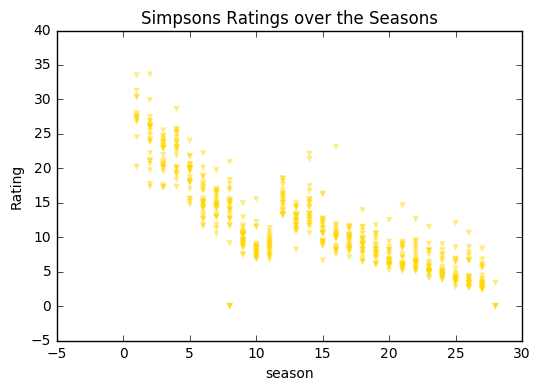

In [23]:
eps.plot('season','us_viewers_in_millions',kind='scatter',title='Simpsons Ratings over the Seasons',
         color='gold',marker='v',alpha=.5,edgecolor='None').set_ylabel('Rating');

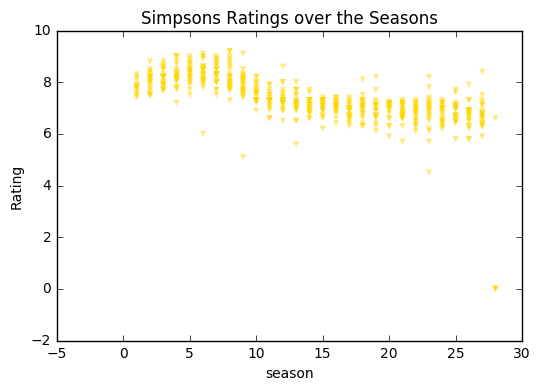

In [ ]:
eps.plot('season','imdb_rating',kind='scatter',title='Simpsons Ratings over the Seasons',
         color='gold',marker='v',alpha=.5,edgecolor='None').set_ylabel('Rating');

In [ ]:
data.plot('month','us_viewers_in_millions',kind = 'bar')

### Another important feature is gender. Since we have text of all of thel ines spoken, we can see how many lines were spoken by fmelaes and males.Females have significantly less lines than males, largely due to the fact that their are significantly less female characters than male.

In [ ]:
data['gender'].value_counts().plot(kind='barh',color='gold',edgecolor='blue').set_ylabel('Gender')
data['gender'].value_counts().plot(kind='barh',color='gold',edgecolor='blue').set_xlabel('Lines');

### We can break character groups down by grouping and sorting based on the number of lines a character has per episode. All chracters who have at least 14 lines per episode are main characters. All characters who have at least 3 lines per episode are secondary characters. All others are "other."

In [ ]:
plt.subplot(1, 3, 1)
(data.groupby("name").count()["id"].sort_values(ascending=False)[0:4]/600).plot(kind='bar',figsize=(15,5),title='Primary Characters').set_ylabel('Lines')
plt.subplot(1, 3, 2)
(data.groupby("name").count()["id"].sort_values(ascending=False)[5:11]/600).plot(kind='bar',title ='Secondary Characters').set_ylabel('Lines')
plt.subplot(1, 3, 3)
(data.groupby("name").count()["id"].sort_values(ascending=False)[12:20]/600).plot(kind='bar',title='Tertiary Characters').set_ylabel('Lines');

In [ ]:
plt.subplot(1, 3, 1)
(data.groupby("raw_location_text").count()["id"].sort_values(ascending=False)[0:1]/600).plot(kind='bar',figsize=(15,5),title='Primary Location').set_ylabel('Lines')
plt.subplot(1, 3, 2)
(data.groupby("raw_location_text").count()["id"].sort_values(ascending=False)[1:5]/600).plot(kind='bar',figsize=(15,5),title='Secondary Locations').set_ylabel('Lines')
plt.subplot(1, 3, 3)
(data.groupby("raw_location_text").count()["id"].sort_values(ascending=False)[5:10]/600).plot(kind='bar',figsize=(15,5),title='All Other').set_ylabel('Lines')

# <span style="color:blue"> Topic Modeling by Genders/Characters/Locations </span>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Since we are using text to analyze The Simpson's dataset, we can use gensim to find topics from different groups of characters and locations withing episodes.

### Using Tfidf to convert text strings into an array of words while removing stop words

In [ ]:
cv = TfidfVectorizer(max_features = 600, 
                             ngram_range=(1, 2),
                             #min_df = 5,
                             #max_df = 0.99,
                             stop_words='english')


docsf = cv.fit_transform(data[data['gender']=='f']['spoken_words'].dropna())
docsm = cv.fit_transform(data[data['gender']=='m']['spoken_words'].dropna())
docshomer = cv.fit_transform(data[data['normalized_name']=='homer simpson']['spoken_words'].dropna())
docsmarge = cv.fit_transform(data[data['normalized_name']=='marge simpson']['spoken_words'].dropna())
docsmain = cv.fit_transform(data[data['char_tier']=='main_character']['spoken_words'].dropna())
docssec = cv.fit_transform(data[data['char_tier']=='secondary_character']['spoken_words'].dropna())
docsloc = cv.fit_transform(data[data['raw_location_text']=="Moe's Tavern"]['spoken_words'].dropna())



id2word = dict(enumerate(cv.get_feature_names()))

In [ ]:
# converting transofrm text to gensim's supported layout
corpusf = Sparse2Corpus(docsf, documents_columns = False)
corpusm = Sparse2Corpus(docsm, documents_columns = False)
corpushomer = Sparse2Corpus(docshomer, documents_columns = False)
corpusmarge = Sparse2Corpus(docsmarge, documents_columns = False)
corpusmain = Sparse2Corpus(docsmain, documents_columns = False)
corpussec = Sparse2Corpus(docssec, documents_columns = False)
corpusloc = Sparse2Corpus(docsloc, documents_columns = False)


lda_modelf = LdaModel(corpus=corpusf, id2word=id2word, num_topics=10)
lda_modelm = LdaModel(corpus=corpusm, id2word=id2word, num_topics=10)
lda_modelhomer = LdaModel(corpus=corpushomer, id2word=id2word, num_topics=10)
lda_modelmarge = LdaModel(corpus=corpusmarge, id2word=id2word, num_topics=10)
lda_modelmain = LdaModel(corpus=corpusmain, id2word=id2word, num_topics=10)
lda_modelsec = LdaModel(corpus=corpussec, id2word=id2word, num_topics=10)
lda_modelloc = LdaModel(corpus=corpusloc, id2word=id2word, num_topics=10)

# Female Topics

#### Although each of the words within each topics are not directly related, there is a clear difference in topics by gender. Female characters tend to reference words like "heart" and "pretty" while mentioning male characters like Moe, Homer, and Barney. They also tend to use the term "losers" although unclear who the term is directed toward. The ability to choose a target in topic modeling can help with that. Males use "glass," likely referring to a drink they'd be receciving at Moe's Tavern. They also mention Homer and use phrases like "lousy" and "yeah yeah."

In [ ]:
num_topics = 5
num_words_per_topic = 5

for ti, topic in enumerate(lda_modelf.show_topics(num_topics = num_topics, 
num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

# Male Topics

In [137]:
num_topics = 5
num_words_per_topic = 5

for ti, topic in enumerate(lda_modelm.show_topics(num_topics = num_topics, 
num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.061*"young" + 0.030*"yeah right" + 0.027*"stop" + 0.027*"moe ve" + 0.026*"sounds"')
()
Topic: 1
(1, u'0.045*"live" + 0.030*"girls" + 0.029*"didn say" + 0.026*"thirty" + 0.023*"glass"')
()
Topic: 2
(2, u'0.036*"don wanna" + 0.032*"hey" + 0.030*"wants" + 0.029*"ve got" + 0.028*"join"')
()
Topic: 3
(3, u'0.064*"numbers" + 0.057*"homer" + 0.039*"round" + 0.035*"sorry homer" + 0.030*"oh right"')
()
Topic: 4
(4, u'0.057*"lenny" + 0.040*"maggie" + 0.028*"uh huh" + 0.019*"make" + 0.017*"oh wait"')
()


# Homer Topics

In [138]:
num_topics = 5
num_words_per_topic = 7

for ti, topic in enumerate(lda_modelhomer.show_topics(num_topics = num_topics, 
num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.055*"real" + 0.037*"machine" + 0.035*"letter" + 0.035*"oh god" + 0.030*"yeah right" + 0.024*"getting" + 0.020*"ve got"')
()
Topic: 1
(1, u'0.037*"kiddin" + 0.033*"use" + 0.026*"ll just" + 0.025*"left" + 0.022*"losers" + 0.021*"gentlemen" + 0.020*"thank"')
()
Topic: 2
(2, u'0.029*"don wanna" + 0.027*"young" + 0.026*"woo hoo" + 0.025*"homer know" + 0.024*"word" + 0.022*"mon" + 0.020*"hours"')
()
Topic: 3
(3, u'0.050*"need" + 0.030*"listen" + 0.029*"joey" + 0.029*"ma" + 0.024*"didn" + 0.021*"talking" + 0.021*"super"')
()
Topic: 4
(4, u'0.044*"hey" + 0.022*"saw" + 0.022*"girls" + 0.020*"watch" + 0.020*"sounds like" + 0.019*"men" + 0.018*"feeling"')
()


# Marge Topics

In [139]:
num_topics = 5
num_words_per_topic = 7

for ti, topic in enumerate(lda_modelmarge.show_topics(num_topics = num_topics, 
num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.033*"moron" + 0.032*"lady" + 0.024*"lucky" + 0.022*"thing" + 0.022*"kiss" + 0.022*"looks like" + 0.022*"dangerous"')
()
Topic: 1
(1, u'0.088*"heart" + 0.040*"bad" + 0.022*"christmas" + 0.020*"thought" + 0.017*"deal" + 0.014*"talk" + 0.013*"lenny"')
()
Topic: 2
(2, u'0.030*"funny" + 0.030*"light" + 0.029*"numbers" + 0.027*"did" + 0.022*"sweet" + 0.021*"loser" + 0.020*"straight"')
()
Topic: 3
(3, u'0.039*"didn say" + 0.031*"hurt" + 0.027*"knows" + 0.024*"lenny" + 0.023*"just" + 0.020*"young" + 0.019*"ll just"')
()
Topic: 4
(4, u'0.073*"hey homer" + 0.035*"ready" + 0.028*"wait" + 0.028*"president" + 0.025*"wasn" + 0.018*"home" + 0.015*"test"')
()


## Main Character Topics

In [140]:
num_topics = 5
num_words_per_topic = 7

for ti, topic in enumerate(lda_modelmain.show_topics(num_topics = num_topics, 
num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.147*"damn" + 0.044*"did" + 0.035*"year" + 0.033*"live" + 0.031*"real" + 0.029*"wanted" + 0.024*"yeah"')
()
Topic: 1
(1, u'0.087*"mean" + 0.045*"using" + 0.038*"glad" + 0.035*"moron" + 0.028*"clown" + 0.028*"learn" + 0.027*"thanks moe"')
()
Topic: 2
(2, u'0.031*"young" + 0.023*"seen" + 0.022*"minute" + 0.021*"thank" + 0.020*"dollars" + 0.017*"rummy" + 0.016*"think ll"')
()
Topic: 3
(3, u'0.048*"don tell" + 0.047*"kid" + 0.033*"joe" + 0.031*"problem" + 0.030*"like" + 0.029*"let" + 0.023*"mad"')
()
Topic: 4
(4, u'0.066*"barn" + 0.051*"hell" + 0.037*"nice" + 0.025*"tv" + 0.022*"gimme" + 0.021*"stand" + 0.021*"lady"')
()


## Secondary Character Topics

In [141]:
num_topics = 7
num_words_per_topic = 7

for ti, topic in enumerate(lda_modelsec.show_topics(num_topics = num_topics, 
num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.065*"homer know" + 0.038*"doin" + 0.018*"goes" + 0.018*"learn" + 0.017*"sir" + 0.016*"tv" + 0.016*"smithers"')
()
Topic: 1
(1, u'0.051*"nice" + 0.036*"help" + 0.023*"homer know" + 0.020*"said" + 0.017*"love" + 0.017*"getting" + 0.015*"yeah"')
()
Topic: 2
(2, u'0.030*"jerks" + 0.024*"late" + 0.021*"look" + 0.021*"blame" + 0.019*"using" + 0.018*"problem" + 0.017*"thank"')
()
Topic: 3
(3, u'0.040*"read" + 0.032*"sorry homer" + 0.025*"years" + 0.022*"afraid" + 0.020*"little" + 0.019*"oh don" + 0.016*"story"')
()
Topic: 4
(4, u'0.039*"like" + 0.029*"tab" + 0.025*"ya" + 0.023*"kiddin" + 0.021*"going" + 0.021*"city" + 0.019*"minutes"')
()


## Moe's Tavern Topics

In [142]:
num_topics = 5
num_words_per_topic = 7

for ti, topic in enumerate(lda_modelloc.show_topics(num_topics = num_topics, 
num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.048*"yeah" + 0.025*"just" + 0.019*"come" + 0.016*"like" + 0.015*"hey" + 0.014*"good" + 0.014*"oh"')
()
Topic: 1
(1, u'0.029*"uh" + 0.022*"moe" + 0.021*"don" + 0.020*"hey" + 0.019*"want" + 0.016*"sure" + 0.015*"tell"')
()
Topic: 2
(2, u'0.023*"okay" + 0.023*"like" + 0.022*"know" + 0.018*"man" + 0.017*"really" + 0.015*"yes" + 0.015*"moe"')
()
Topic: 3
(3, u'0.036*"homer" + 0.018*"beer" + 0.018*"hey" + 0.017*"got" + 0.017*"oh" + 0.015*"barney" + 0.015*"ve"')
()
Topic: 4
(4, u'0.040*"oh" + 0.028*"ll" + 0.025*"right" + 0.019*"let" + 0.017*"eh" + 0.015*"shut" + 0.012*"way"')
()


# Sentiment Analysis

### Using sentiment analysis, we can take a closer look into the text of the characters' lines and who is most positive, who is most negative, where characters tend to be positive, and how these factors contribute to success

In [143]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
        return features


In [144]:
training_set = nltk.classify.apply_features(extract_features, cv)

TypeError: 'TfidfVectorizer' object does not support indexing

# <span style="color:blue"> K-Means Clustering </span>

### Finally, to find groups of episodes that are similar, we can use clustering. Clustering can be used on the quantitative data such as word count, viewers, season number (Which indicates older v newer episodes), and the amount of lines.

In [20]:
scale = StandardScaler()

In [87]:
datanum = data[['season','word_count','month','main_character','secondary_character','tertiary_character','main_location','tertiary_location','us_viewers_in_millions']].fillna(0)

In [88]:
X_scale = scale.fit_transform(datanum)

### Finding the "Elbow"

Although there is no clear way to determine the amount of clusters that will give you the "best" accuracy score, plotting inertia against different values of clusters can help. The largest slope change suggests the best value to use. The plot below displays how inertia changes as we increase k. When looking for the "elbow," the best k seems to be 3.

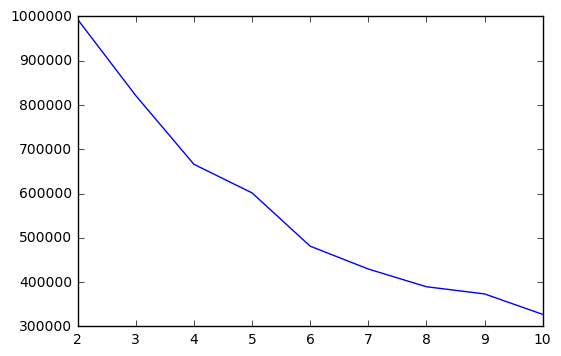

In [84]:
x = []
y = []
for n in range(2,11):
    km = KMeans(n_clusters=n, random_state=0)
    km.fit(X_scale)
    x.append(n)
    y.append(km.inertia_)
plt.plot(x,y)

In [89]:
%%time
km = KMeans(n_clusters=9, n_init=5,random_state=10)
km.fit(X_scale)

Wall time: 3.03 s


### Inertia tells us how good our groups are by summing the distances of each data point to the cluster center.

In [90]:
print km.inertia_

359995.913473


### K-Means identifies the kinds of clusters in our data. 
### Cluster 0: Many lines spoken, fewer viewers, newer episodes, and a few words spoken per line
### Cluster 1: Few lines spoken, 16 million viewers, older episodes, and a few words spoke per line
### Cluster 2: Few lines spoken, large amount of viewers, older episodes, and significantly more words spoken per line

In [91]:
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,len(km.cluster_centers_))}
simpsons_clusters = pd.DataFrame(columns, index=datanum.columns)

In [92]:
simpsons_clusters

,0,1,2,3,4,5,6,7,8
season,1.693215e+01,5.417504e+00,1.688735e+01,1.707261e+01,1.309296e+01,5.222117e+00,5.037747e+00,9.0000,1.705130e+01
word_count,9.217250e+00,8.575927e+00,9.164442e+00,2.618809e+01,1.072765e+01,1.018834e+01,3.181398e+01,885500.0000,9.213330e+00
month,1.082606e+01,6.128864e+00,6.151573e+00,5.989258e+00,6.008281e+00,5.465108e+00,6.561219e+00,5.2500,3.147614e+00
main_character,-1.211808e-13,1.000000e+00,7.879462e-01,1.000000e+00,-1.431077e-13,-1.503242e-13,7.953232e-01,0.2500,-2.250422e-13
secondary_character,-1.261491e-14,2.470246e-15,1.769418e-14,4.352074e-14,1.000000e+00,-1.720846e-15,-2.034484e-14,0.0000,2.611800e-14
tertiary_character,1.000000e+00,1.141864e-13,2.120538e-01,-4.546363e-14,9.209300e-14,1.000000e+00,2.046768e-01,0.7500,1.000000e+00
main_location,4.066192e-14,4.388157e-14,1.000000e+00,5.273559e-14,1.159975e-01,4.304890e-14,1.000000e+00,0.0000,4.896084e-14
tertiary_location,8.727094e-01,8.893612e-01,-8.948398e-14,8.973111e-01,6.449795e-01,8.433426e-01,-8.415491e-14,1.0000,8.693158e-01
us_viewers_in_millions,9.618207e+00,1.981074e+01,8.713367e+00,8.603261e+00,1.213288e+01,1.954110e+01,2.001656e+01,17.2675,8.380142e+00


In [93]:
path = 'C:\\Users\\janel\\Documents\\DAT-NYC-45\\final-project\\4'

In [94]:
import os

In [95]:
simpsons_clusters.to_csv(os.path.join(path, 'simpsons_clusters.csv'))

### In the future, I'd like to create more features that may be meaningful, like the number of characters per episode, the number of locations present within the episode, the average amount of viewers per month (to account for special holiday episodes), and episodes that involve topics listed above. In addition, I'd like to complete sentiment analysis for each of the lines, transform this into a binary variable to use when clustering. This way we can find information such as: "Successful episodes often involve an angry conversational Homer Simpson at Moe's Tavern"